In [1]:
import pandas as pd
import numpy as np
from statsmodels.duration.hazard_regression import PHReg

import re

import seaborn as sns

sns.set_style('white')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Lifelines stuff
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.statistics import multivariate_logrank_test
from lifelines.statistics import pairwise_logrank_test

kmf = KaplanMeierFitter()

In [3]:
freq = pd.read_csv('./Data/sarcoma_frequencies.txt', sep='\t')
freq.Count = freq.Count.map(lambda x: int(x.replace(',', '')))

In [4]:
metastatic_survival = pd.read_csv('./Data/metastatic_sarcoma_survival.txt', sep='\t', index_col=0)
local_survival = pd.read_csv('./Data/localized_sarcoma_survival.txt', sep='\t', index_col=0)
local_location = pd.read_csv('./Data/localized_sarcoma_location.txt', sep='\t', index_col=0)

metastatic_survival['age'] = metastatic_survival['Age recode with single ages and 85+'].map(lambda x: int(re.match('([0-9]+).+', x).group(1)))

## Metastatic Sarcoma

In [5]:
histology = 'leiomyosarcoma'
cutoff = 20

specific_histology = metastatic_survival[metastatic_survival['ICD-O-3 Hist/behav, malignant'].map(lambda x: histology in x.lower())]
specific_histology_available = specific_histology[specific_histology['Survival months'] != 'Unknown']

counts = specific_histology_available['ICD-O-3 Hist/behav, malignant'].value_counts()
count_index = counts[counts > cutoff].index.values

filt_hist = specific_histology_available.set_index('ICD-O-3 Hist/behav, malignant').ix[count_index]
filt_hist['Survival months'] = filt_hist['Survival months'].astype(int)
filt_hist['censored'] = filt_hist['Vital status recode (study cutoff used)'].map({'Dead':1, 'Alive':0})

(0, 60)

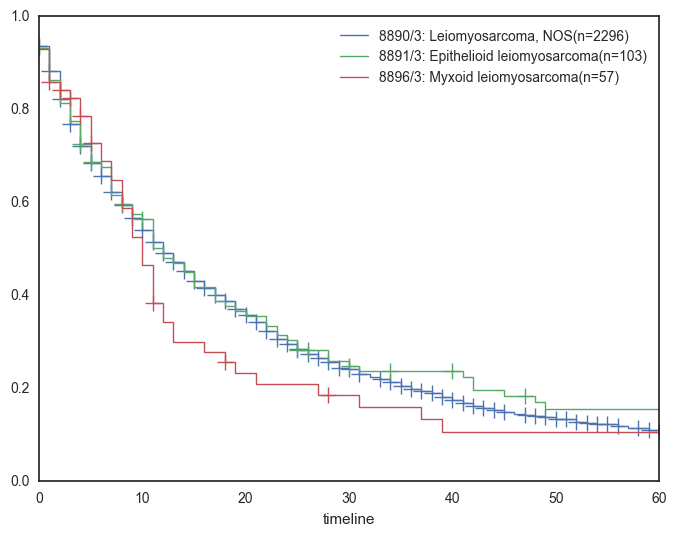

In [6]:
fig = plt.figure(figsize=(8, 6)) 
ax = plt.subplot(1,1,1)


for tumor_type in filt_hist.index.unique():

    data = filt_hist.ix[tumor_type]
    kmf.fit(data['Survival months'], data['censored'], label=tumor_type +  "(n=" + str(len(data)) + ")")
    kmf.plot(ax=ax, ci_show=False, linewidth=1, show_censors=True)
    
plt.xlim([0,60])

### Combine most common counts

In [8]:
metastatic_survival['ICD-O-3 Hist/behav, malignant'].value_counts()

8890/3: Leiomyosarcoma, NOS                            2300
8800/3: Sarcoma, NOS                                   1318
9120/3: Hemangiosarcoma                                 548
8801/3: Spindle cell sarcoma                            475
8830/3: Malignant fibrous histiocytoma                  467
8802/3: Giant cell sarcoma                              272
9540/3: Malignant peripheral nerve sheath tumor         199
9040/3: Synovial sarcoma, NOS                           154
8900/3: Rhabdomyosarcoma, NOS                           150
8804/3: Epithelioid sarcoma                             139
8920/3: Alveolar rhabdomyosarcoma                       129
8806/3: Desmoplastic small round cell tumor             125
8805/3: Undifferentiated sarcoma                        124
9260/3: Ewing sarcoma                                   109
8891/3: Epithelioid leiomyosarcoma                      104
9041/3: Synovial sarcoma, spindle cell                   96
9364/3: Peripheral neuroectodermal tumor

In [9]:
#common_types = ['leiomyosarcoma', 'hemangiosarcoma', 'spindle cell', 'giant cell', 'malignant fibrous histiocytoma', 'synovial', 'rhabdomyosarcoma', 'epithelioid', 'desmoplastic small round cell', 'ewing', 'alveolar soft part', 'liposarcoma']
common_types = ['leiomyosarcoma', 'malignant fibrous histiocytoma', 'synovial', 'rhabdomyosarcoma', 'desmoplastic small round cell', 'ewing', 'alveolar soft part', 'liposarcoma']

def mapSarcomaType(line):
    for hist in common_types:
        if hist in line.lower():
            return hist
    
    return 'none'

In [10]:
filt_ms = metastatic_survival.copy()
filt_ms['histology_filt'] = metastatic_survival['ICD-O-3 Hist/behav, malignant'].map(mapSarcomaType)
filt_ms = filt_ms[filt_ms.histology_filt != 'none']
filt_ms = filt_ms[filt_ms['Survival months'] != 'Unknown']

filt_ms['Survival_months'] = filt_ms['Survival months'].astype(int)
filt_ms['censored'] = filt_ms['Vital status recode (study cutoff used)'].map({'Dead':1, 'Alive':0})

C:\Users\namqb\Anaconda2\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


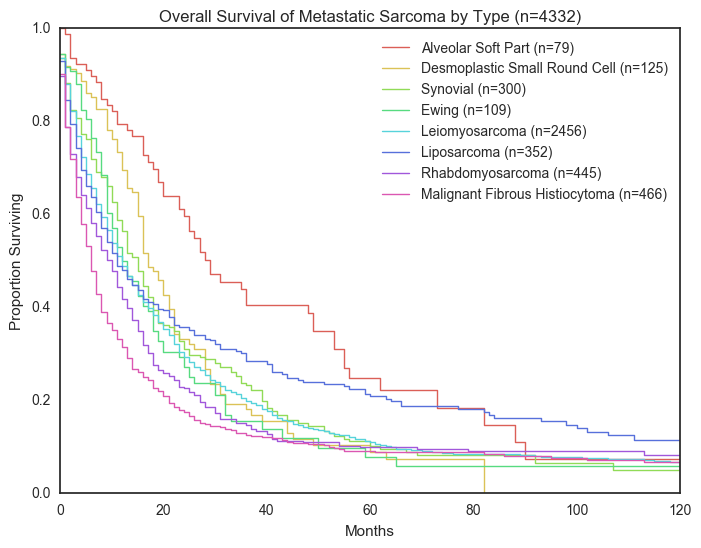

In [11]:
sns.set_palette(sns.color_palette("hls", 8))

ms_gby = filt_ms.groupby('histology_filt')

fig = plt.figure(figsize=(8, 6)) 
ax = plt.subplot(1,1,1)

median_survival = []

for name, group in ms_gby:
    group = group[group.censored == 1]
    median_survival.append([name, group['Survival_months'].median()])

survival_order = pd.DataFrame(zip(*median_survival)).T.sort(1, ascending=False)[0].values
    
num_pts = 0
    
for name in survival_order:
    group = filt_ms.set_index('histology_filt').ix[name]
    kmf.fit(group['Survival_months'], group['censored'], label=name.title() +  " (n=" + str(len(group)) + ")")
    kmf.plot(ax=ax, ci_show=False, linewidth=1, show_censors=False)

plt.xlim([0,120])
sns.set_palette('deep')

plt.title('Overall Survival of Metastatic Sarcoma by Type (n=' + str(len(filt_ms)) + ')')
plt.xlabel('Months')
plt.ylabel('Proportion Surviving')

### Fitting Cox PH 

In [26]:
mod = PHReg.from_formula("Survival_months ~ age + histology_filt", filt_ms, status=filt_ms.censored, ties="efron")
rslt = mod.fit()
rslt.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: PHReg
======================================================================================================
Model:                               PH Reg                          Sample size:                 5839
Dependent variable:                  Survival_months                 Num. events:                 4807
Ties:                                Efron                                                            
------------------------------------------------------------------------------------------------------
                                                  log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------------------------------------------------
Intercept                                         0.0000       nan 1.0000     nan    nan    nan    nan
histology_filt[T.desmoplastic small round cell]   0.3868    0.1173 1.4722  3.2962 0.0010 1.1698 1.8529
histology_filt[T.epithelioid]                     0.2810    0.1073 1.3244  2.6189 0.0088 1.0732 1.6343
histology_filt[T.ewing]                           0.5258    0.1219 1.6918  4.3152 0.0000 1.3324 2.1482
histology_filt[T.giant cell]                      0.2392    0.1046 1.2702  2.2868 0.0222 1.0348 1.5592
histology_filt[T.hemangiosarcoma]                 0.6236    0.0917 1.8657  6.7975 0.0000 1.5586 2.2332
histology_filt[T.leiomyosarcoma]                  0.0000    0.0824 1.0000  0.0002 0.9998 0.8509 1.1753
histology_filt[T.liposarcoma]                    -0.1498    0.1012 0.8609 -1.4802 0.1388 0.7060 1.0498
histology_filt[T.malignant fibrous histiocytoma]  0.1793    0.0991 1.1964  1.8092 0.0704 0.9852 1.4529
histology_filt[T.rhabdomyosarcoma]                0.5828    0.0816 1.7911  7.1456 0.0000 1.5265 2.1016
histology_filt[T.spindle cell]                    0.4177    0.0883 1.5185  4.7313 0.0000 1.2772 1.8054
histology_filt[T.synovial]                        0.2497    0.1040 1.2837  2.4019 0.0163 1.0470 1.5739
age                                               0.0201    0.0009 1.0204 23.2936 0.0000 1.0186 1.0221
======================================================================================================
Confidence intervals are for the hazard ratios
"""

## Localized Sarcoma

In [121]:
local_survival['ICD-O-3 Hist/behav, malignant'].value_counts()

8890/3: Leiomyosarcoma, NOS                           6717
8830/3: Malignant fibrous histiocytoma                4154
8800/3: Sarcoma, NOS                                  2539
8851/3: Liposarcoma, well differentiated              2046
8852/3: Myxoid liposarcoma                            1601
9120/3: Hemangiosarcoma                               1562
8811/3: Fibromyxosarcoma                              1536
8802/3: Giant cell sarcoma                            1512
8832/3: Dermatofibrosarcoma, NOS                      1250
8801/3: Spindle cell sarcoma                          1218
9540/3: Malignant peripheral nerve sheath tumor       1092
8850/3: Liposarcoma, NOS                               973
8858/3: Dedifferentiated liposarcoma                   801
8810/3: Fibrosarcoma, NOS                              614
9040/3: Synovial sarcoma, NOS                          571
8854/3: Pleomorphic liposarcoma                        557
9041/3: Synovial sarcoma, spindle cell                 5

In [22]:
histology = 'synovial'

specific_histology = local_survival[local_survival['ICD-O-3 Hist/behav, malignant'].map(lambda x: histology.lower() in x.lower())]
specific_histology_available = specific_histology[specific_histology['Survival months'] != 'Unknown']

filt_hist = specific_histology_available.set_index('ICD-O-3 Hist/behav, malignant')
filt_hist['Survival months'] = filt_hist['Survival months'].astype(int)
filt_hist['censored'] = filt_hist['Vital status recode (study cutoff used)'].map({'Dead':1, 'Alive':0})

Results
   df: 1
   alpha: 0.95
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00272 |              8.983 |      Reject Null    |        True       


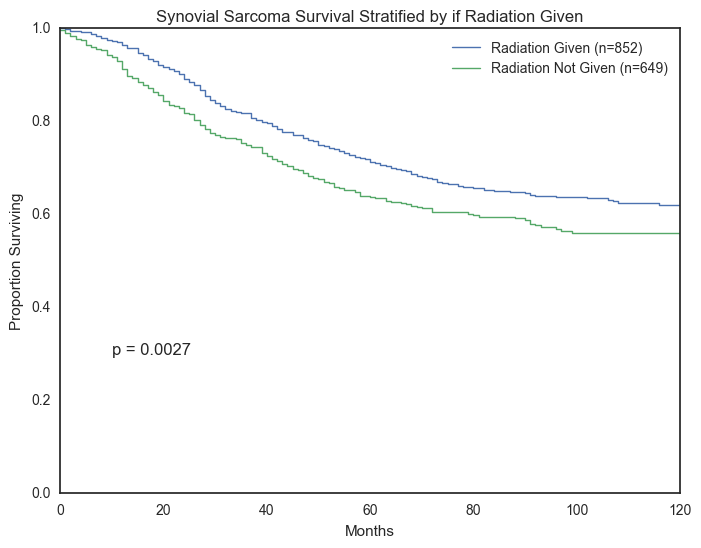

In [42]:
radiation_given = ['Beam radiation', 'Combination of beam with implants or isotopes', 'Radioactive implants', 'Radiation, NOS method or source not specified']

rad_df = filt_hist[filt_hist.Radiation.map(lambda x: x in radiation_given)]
non_rad_df = filt_hist[~filt_hist.Radiation.map(lambda x: x in radiation_given)]

fig = plt.figure(figsize=(8, 6)) 
ax = plt.subplot(1,1,1)

data = rad_df
kmf.fit(data['Survival months'], data['censored'], label='Radiation Given (n=' + str(len(data)) + ")")
kmf.plot(ax=ax, ci_show=False, linewidth=1, show_censors=False)

data2 = non_rad_df
kmf.fit(data2['Survival months'], data2['censored'], label='Radiation Not Given (n=' + str(len(data2)) + ")")
kmf.plot(ax=ax, ci_show=False, linewidth=1, show_censors=False)

plt.xlim([0,120])
plt.ylim([0,1])

results = logrank_test(data['Survival months'], data2['Survival months'], data['censored'], data2['censored'], alpha=.95 )
results.print_summary()

plt.title(histology.title() + ' Sarcoma Survival Stratified by if Radiation Given')
plt.xlabel('Months')
plt.ylabel('Proportion Surviving')
plt.text(10, 0.3, 'p = ' + '{0:.4f}'.format(results.p_value), size=12)


## Synovial Sarcoma Location

In [11]:
def mapLocation(line):
    line = line.lower()
    if 'limb' in line:
        return 'extremity'
    elif 'trunk' in line:
        return 'trunk'
    elif 'pelvis' in line:
        return 'trunk'
    elif ('thorax' in line) | ('lung' in line):
        return 'lung'
    else:
        return line
    

In [15]:
vc = local_location['Primary Site - labeled'].map(mapLocation).value_counts()

In [17]:
vc/vc.sum()

extremity                                                     0.638474
lung                                                          0.112903
trunk                                                         0.074744
c49.0-conn, subcutaneous, other soft tis: head, face, neck    0.042486
c49.4-conn, subcutaneous, other soft tis: abdomen             0.031078
c49.9-conn, subcutaneous and other soft tissues, nos          0.014162
c64.9-kidney, nos                                             0.009048
c38.4-pleura, nos                                             0.008261
c80.9-unknown primary site                                    0.006294
c48.0-retroperitoneum                                         0.005901
c38.0-heart                                                   0.004721
c38.3-mediastinum, nos                                        0.003934
c07.9-parotid gland                                           0.003147
c38.2-posterior mediastinum                                   0.002360
c32.1-